In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Uplift Modeling

In [253]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('telecom_data/WA_Fn-UseC_-Telco-Customer-Churn.csv', low_memory=False)

In [254]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [255]:
df.describe(exclude='number').T

,count,unique,top,freq
customerID,7043,7043,6050-FFXES,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


In [234]:
df['MonthlyCharges'] = df.MonthlyCharges.astype(int)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df = df.replace({'PaperlessBilling': {'Yes': 1, 'No': 0}})
df = df.replace({'Churn': {'Yes': 1, 'No': 0}})

In [235]:
df = df.dropna().reset_index(drop=True)

In [236]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   int64  


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70,151.65,1


In [237]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X=df.drop('Churn', axis=1)  # Features
y=df['Churn']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [238]:
indices_learn = list(X_train.index)
indices_valid = list(X_val.index)
treat_train = X_train.loc[indices_learn, 'PaperlessBilling']
treat_val =  X_val.loc[indices_valid, 'PaperlessBilling']

In [239]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier

cat_features = list(df.select_dtypes(exclude=['float', 'int']).columns.difference(['Churn']))
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [240]:
def plot_uplift_preds(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    #check_consistent_length(trmnt_preds, ctrl_preds)
    #check_is_binary(treatment)

    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

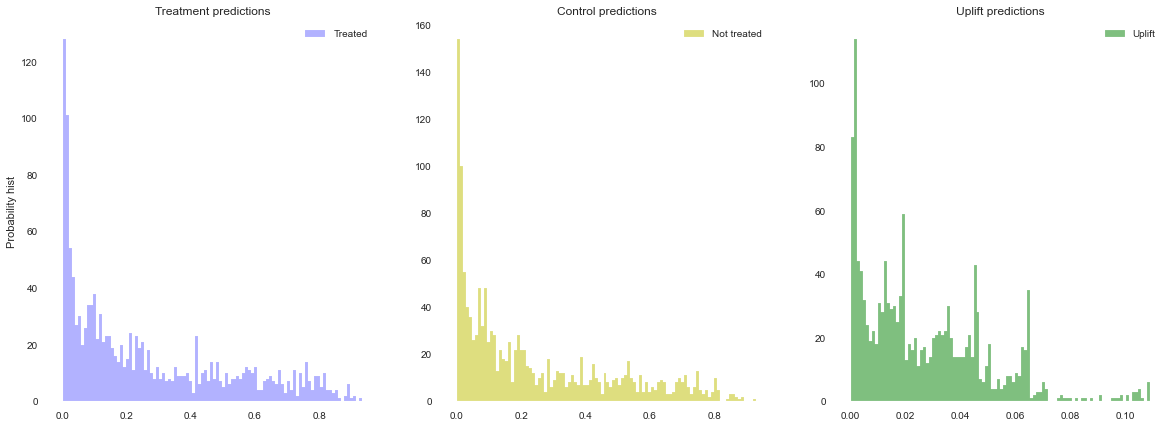

In [241]:
# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [242]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,Contract,24.548392
1,tenure,14.300963
2,TotalCharges,9.322038
3,MultipleLines,6.948776
4,InternetService,6.710528
5,PaymentMethod,6.391267
6,OnlineBackup,5.294285
7,Dependents,4.464290
8,StreamingTV,4.206875
9,MonthlyCharges,4.137758


In [243]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [244]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.643041
0,SoloModel,0.289071


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.1103'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

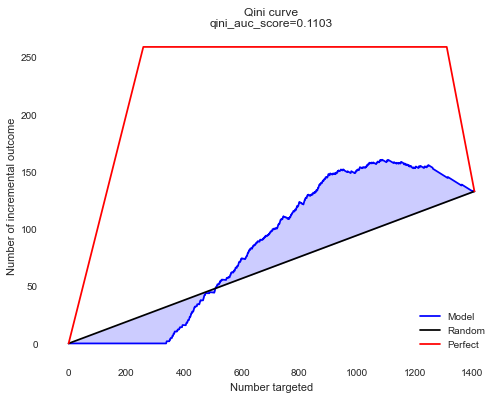

In [246]:
# import vizualisation tools
from sklift.viz import plot_qini_curve

plot_qini_curve(y_true=y_val, uplift=uplift_ct, treatment=treat_val, negative_effect=True)